In [60]:
# Data Manipulation
import numpy as np
import pandas as pd
import os
# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPooling2D, Dense, Activation, Dropout
from PIL import Image
# Other
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
import xml.etree.ElementTree as ET
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [61]:
#Codice per rendere l'immagine quadrata 
def make_square(im, fill_color=(0, 0, 0, 0)):
    x, y = im.shape[0], im.shape[1]
    size = max(x, y)
    BLACK = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im,int((size-y)/2),int((size-y)/2),int((size-x)/2),int((size-x)/2),cv2.BORDER_CONSTANT, value = BLACK)
    return new_im

In [62]:
#Bounding box with one tumor
lab = ['axial_t1wce_2_class','coronal_t1wce_2_class', 'sagittal_t1wce_2_class']
X_train = []
bb = []
temp_array  = []
image_size = 227
for i in lab:
    folderPath = os.path.join('./',i,'images','train')
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        if img.shape[0] != img.shape[1]:
            img = make_square(img, fill_color=(0, 0, 0, 0))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
image_index = 0
bb_train = np.zeros((len(X_train),4))
for i in lab:
    labelsPath = os.path.join('./',i,'labels','train')
    for j in tqdm(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    k = k * image_size
                    temp_array.append(k)
                temp_array.pop(0)
                #print(temp_array)
                bb_train[image_index] = np.array([temp_array])
                #print(bb_train[image_index])
            image_index += 1

X_test = []
for i in lab:
    folderPath = os.path.join('./',i,'images','test')
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        if img.shape[0] != img.shape[1]:
            img = make_square(img, fill_color=(0, 0, 0, 0))
        img = cv2.resize(img,(image_size, image_size))
        X_test.append(img)
image_index = 0
bb_test = np.zeros((len(X_test),4))
for i in lab:
    labelsPath = os.path.join('./',i,'labels','test')
    for j in tqdm(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    k = k * image_size
                    temp_array.append(k)
                temp_array.pop(0)
                #print(temp_array)
                bb_test[image_index] = np.array([temp_array])
                #print(bb_test[image_index])
            image_index += 1

100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 1839.24it/s]


In [63]:
#prepare dataset 
train_dataset = ImageDataGenerator()
val_dataset = ImageDataGenerator()

In [64]:
#array conversion
X_train = np.array(X_train)
X_test = np.array(X_test)

In [65]:
#Shuffle
X_train, bb_train = shuffle(X_train, bb_train)

In [66]:
#Validation set created
X_train, X_val, bb_train, bb_val = train_test_split(X_train, bb_train, test_size = 0.1, shuffle = False)

In [67]:
tf.keras.backend.set_image_data_format('channels_last')
BATCH_SIZE = 16
save_path = os.path.join('./', 'model_from_scratch')
train_dataset = train_dataset.flow(X_train, bb_train, batch_size = BATCH_SIZE)
val_dataset = val_dataset.flow(X_val, bb_val, batch_size = BATCH_SIZE)

In [9]:
#Data augmentation
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        #layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ],
    name="img_augmentation",
)

In [81]:
# Creating a Sequential model
model = Sequential()

# 1st Convolution Layer
model.add(Conv2D(filters=96, kernel_size=(11,11), input_shape=(227, 227, 3), strides=(4,4), padding='valid'))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))
# Max-Pooling
model.add(MaxPooling2D((3,3), strides=(2,2), padding='valid'))

# 2nd Convolution Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))
# Max-Pooling
model.add(MaxPooling2D((3,3), strides=(2,2), padding='valid'))

# 3rd Convolution Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same'))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))

# 4th Convolution Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same'))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))

# 5th Convolution Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))
# Max-Pooling
model.add(MaxPooling2D((3,3), strides=(2,2), padding='valid'))

# Flattening before passing to the Dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))

# 2nd Dense Layer
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))

# Output softmax Layer
model.add(Dense(4))
# Activation Function
model.add(Activation('softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_164 (Conv2D)         (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_55 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_165 (Conv2D)         (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_56 (Bat  (None, 27, 27, 256)     

In [82]:
# declaring the input layer
# In the original paper the network consisted of only one channel.
inputs = layers.Input(shape=(572, 572, 1))
# first part of the U - contracting part
c0 = layers.Conv2D(64, activation='relu', kernel_size=3)(inputs)
c1 = layers.Conv2D(64, activation='relu', kernel_size=3)(c0)  # This layer for concatenating in the expansive part
c2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c1)

c3 = layers.Conv2D(128, activation='relu', kernel_size=3)(c2)
c4 = layers.Conv2D(128, activation='relu', kernel_size=3)(c3)  # This layer for concatenating in the expansive part
c5 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c4)

c6 = layers.Conv2D(256, activation='relu', kernel_size=3)(c5)
c7 = layers.Conv2D(256, activation='relu', kernel_size=3)(c6)  # This layer for concatenating in the expansive part
c8 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c7)

c9 = layers.Conv2D(512, activation='relu', kernel_size=3)(c8)
c10 = layers.Conv2D(512, activation='relu', kernel_size=3)(c9)  # This layer for concatenating in the expansive part
c11 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c10)

c12 = layers.Conv2D(1024, activation='relu', kernel_size=3)(c11)
c13 = layers.Conv2D(1024, activation='relu', kernel_size=3, padding='valid')(c12)

# We will now start the second part of the U - expansive part
t01 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(c13)
crop01 = layers.Cropping2D(cropping=(4, 4))(c10)

concat01 = layers.concatenate([t01, crop01], axis=-1)

c14 = layers.Conv2D(512, activation='relu', kernel_size=3)(concat01)
c15 = layers.Conv2D(512, activation='relu', kernel_size=3)(c14)

t02 = layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu')(c15)
crop02 = layers.Cropping2D(cropping=(16, 16))(c7)

concat02 = layers.concatenate([t02, crop02], axis=-1)

c16 = layers.Conv2D(256, activation='relu', kernel_size=3)(concat02)
c17 = layers.Conv2D(256, activation='relu', kernel_size=3)(c16)

t03 = layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu')(c17)
crop03 = layers.Cropping2D(cropping=(40, 40))(c4)

concat03 = layers.concatenate([t03, crop03], axis=-1)

c18 = layers.Conv2D(128, activation='relu', kernel_size=3)(concat03)
c19 = layers.Conv2D(128, activation='relu', kernel_size=3)(c18)

t04 = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu')(c19)
crop04 = layers.Cropping2D(cropping=(88, 88))(c1)

concat04 = layers.concatenate([t04, crop04], axis=-1)

c20 = layers.Conv2D(64, activation='relu', kernel_size=3)(concat04)
c21 = layers.Conv2D(64, activation='relu', kernel_size=3)(c20)

model = layers.Conv2D(2, kernel_size=1)(c21)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Flatten()(model)
outputs = tf.keras.layers.Dense(4,name='coords')(model)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-netmodel")

model.summary()

Model: "u-netmodel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 572, 572, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_169 (Conv2D)            (None, 570, 570, 64  640         ['input_20[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_170 (Conv2D)            (None, 568, 568, 64  36928       ['conv2d_169[0][0]']             
                                )                                                        

                                8)                                                                
                                                                                                  
 conv2d_184 (Conv2D)            (None, 196, 196, 12  147584      ['conv2d_183[0][0]']             
                                8)                                                                
                                                                                                  
 conv2d_transpose_22 (Conv2DTra  (None, 392, 392, 64  32832      ['conv2d_184[0][0]']             
 nspose)                        )                                                                 
                                                                                                  
 cropping2d_19 (Cropping2D)     (None, 392, 392, 64  0           ['conv2d_170[0][0]']             
                                )                                                                 
          

In [83]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True
    ),
    ShowTestImages()
]

In [15]:
IMG_SIZE = 180
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
model = img_augmentation(inputs)
model = keras.applications.efficientnet.preprocess_input(model)
model = conv_base(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(4,name='coords')(model)
model = tf.keras.models.Model(inputs=inputs, outputs = model)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 180, 180, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 6, 6, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0     

In [84]:
model.compile(
    loss={
        'coords': 'mae'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

In [85]:
model.fit(
        train_dataset,
        epochs=5,
        validation_data = val_dataset,
        callbacks = callbacks_list
        )

Epoch 1/5


UnimplementedError: Graph execution error:

Detected at node 'u-netmodel/conv2d_169/Relu' defined at (most recent call last):
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\alexi\AppData\Local\Temp\ipykernel_23016\572828044.py", line 1, in <module>
      model.fit(
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\layers\convolutional\base_conv.py", line 278, in call
      return self.activation(outputs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\backend.py", line 4992, in relu
      x = tf.nn.relu(x)
Node: 'u-netmodel/conv2d_169/Relu'
Fused conv implementation does not support grouped convolutions for now.
	 [[{{node u-netmodel/conv2d_169/Relu}}]] [Op:__inference_train_function_13429]

In [71]:
# Draw the predicted bounding boxes
def display_image(img, bbox_coords, pred_coords):
    if len(bbox_coords) == 4: #in rosso
        xmin, ymin, height, width = bbox_coords
        img = cv2.rectangle(img, (int(xmin-height/2), int(ymin-width/2)), (int(xmin+height/2), int(ymin+width/2)), (255, 0, 0), 1)
        
    if len(pred_coords) == 4: #in verde
        xmin1, ymin1, height1, width1 = pred_coords
        img = cv2.rectangle(img, (int(xmin1-height1/2), int(ymin1-width1/2)), (int(xmin1+height1/2), int(ymin1+width1/2)), (0, 255, 0), 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [72]:
#To test the model
def test_model(model):
    rand_index = np.random.randint(0, bb_test.shape[0])
    pred_bbox = model.predict(X_test)[rand_index]
    img_original = X_test[rand_index]
    img = img_original.copy()
    coords = bb_test[rand_index]
    #example, label = next(datagen)
    #X = example['image']
    #y = label['coords']
    #pred_bbox = model.predict(X)[0]
    #img = X[0]
    #gt_coords = y[0]
    
    display_image(img,bbox_coords = coords, pred_coords=pred_bbox)

def test(model):
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model)    
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)
        

In [49]:
#Save model
model.save('./model_efficientNet')

INFO:tensorflow:Assets written to: ./model_efficientNet\assets


INFO:tensorflow:Assets written to: ./model_efficientNet\assets


In [37]:
#Save model
model.save('./model_from_scratch')

INFO:tensorflow:Assets written to: ./model_from_scratch\assets


INFO:tensorflow:Assets written to: ./model_from_scratch\assets


In [12]:
model = tf.keras.models.load_model('./model_efficientNet')

In [36]:
model = tf.keras.models.load_model('./model_from_scratch')

<AxesSubplot:>

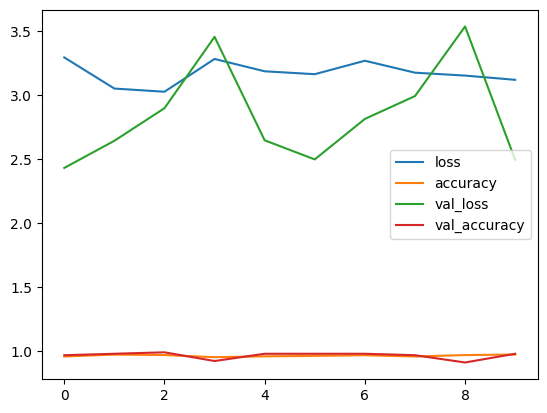

In [50]:
pd.DataFrame(model.history.history).plot()